In [1]:
import os
import multiprocessing
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

import warnings

from scipy.optimize import curve_fit
from scipy.stats import lognorm

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
dir_path = '/dlabdata1/gligoric/tweets_lengths_longitudinal_v2/derived_dataset'

In [4]:
i = 0
filepath = os.path.join(dir_path, f"lengths_derived_dataset_batch_{i+1}.parquet")
df = pd.read_parquet(filepath, columns=['lang', 'n_chars', 'created_at'])
df = df[(df["created_at"].dt.year == 2017) & (df["created_at"].dt.month < 11)]
before = df.loc[df['lang'] == 'en'].n_chars
del df

In [5]:
i = 39
filepath = os.path.join(dir_path, f"lengths_derived_dataset_batch_{i+1}.parquet")
df = pd.read_parquet(filepath, columns=['lang', 'n_chars', 'created_at'])
df = df[(df["created_at"].dt.year == 2019) & (df["created_at"].dt.month < 11)]
after = df.loc[df['lang'] == 'en'].n_chars
del df

In [6]:
n_char_hist = before.value_counts()
hist_before = np.array([(n_char_hist[i]) / np.nansum(n_char_hist) \
                          if i in n_char_hist.index \
                          else 0 \
                          for i in range(1, 141)])

In [7]:
n_char_hist = after.value_counts()
hist_after = np.array([(n_char_hist[i]) / np.nansum(n_char_hist) \
                          if i in n_char_hist.index \
                          else 0 \
                          for i in range(1, 281)])

In [8]:
print(f"stats: mu: {before.mean()}, sigma: {before.std()}")
print(f"logged data stats: {np.log(before).mean()}, {np.log(before).std()}")

stats: mu: 69.01628380777986, sigma: 39.634238535231596
logged data stats: 4.036474052830845, 0.674794913069854


In [9]:
cramming_threshold_after = 235
cramming_threshold_before = 115

scipy floc=0,        mu: 4.036474, sigma: 0.674795, exp(mu): 56.626329
manual full,         mu: 4.153019, sigma: 0.778653, exp(mu): 63.625816
cut at cramming threshold,          mu: 4.088451, sigma: 0.759873, exp(mu): 59.647429
manual lognorm cut,          mu: 4.092558, sigma: 0.760651, exp(mu): 59.892896


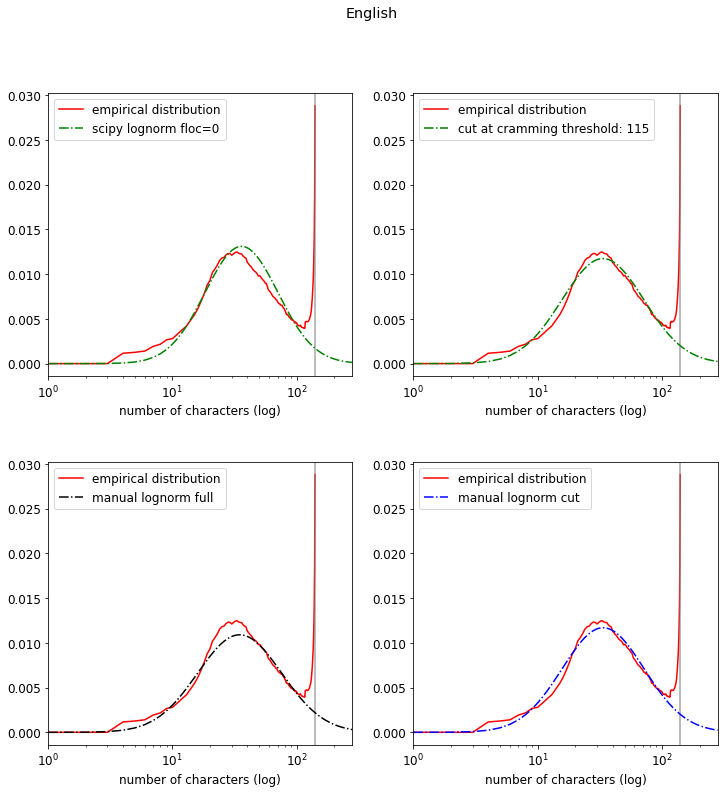

In [10]:
def lognormal_func(x, mu, sigma) :
    return 1 / (np.sqrt(2 * np.pi) * sigma * x) * np.exp(-((np.log(x) - mu)**2) \
                                                         / (2 * sigma**2))

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['font.size'] = 12

params = lognorm.fit(before.values, floc=0)
sigma1, _, mu1_exped = params
print(f"scipy floc=0,        mu: {np.log(mu1_exped):2f}, sigma: {sigma1:2f}, exp(mu): {mu1_exped:2f}")

params = curve_fit(lognormal_func, np.arange(1, 141), hist_before)
mu3, sigma3 = params[0]
print(f"manual full,         mu: {mu3:2f}, sigma: {sigma3:2f}, exp(mu): {np.exp(mu3):2f}")

params = curve_fit(lognormal_func, np.arange(1, cramming_threshold_before+1), hist_before[:cramming_threshold_before])
mu2, sigma2 = params[0]
print(f"cut at cramming threshold,          mu: {mu2:2f}, sigma: {sigma2:2f}, exp(mu): {np.exp(mu2):2f}")

params = curve_fit(lognormal_func, np.arange(1, 121), hist_before[:120])
mu4, sigma4 = params[0]
print(f"manual lognorm cut,          mu: {mu4:2f}, sigma: {sigma4:2f}, exp(mu): {np.exp(mu4):2f}")


fig, axes = plt.subplots(2, 2)

for row in axes:
    for ax in row:
        ax.plot(range(1, 141), hist_before, color='red', label='empirical distribution')
        ax.axvline(x=140, color='gray', alpha=0.7)
        ax.set_xlim(1, 280)
        ax.set_xscale("log")
        ax.set_xlabel("number of characters (log)")
    
axes[0][0].plot(range(1, 280), [lognorm.pdf(x, s=sigma1, loc=0, scale=mu1_exped) for x in range(1, 280)],\
        color='green', linestyle='-.', label="scipy lognorm floc=0")
axes[0][0].legend()

axes[0][1].plot(range(1, 280), [lognormal_func(x, mu2, sigma2) for x in range(1, 280)],\
        color='green', linestyle='-.', label=f"cut at cramming threshold: {cramming_threshold_before}")
axes[0][1].legend()


axes[1][0].plot(range(1, 280), [lognormal_func(x, mu3, sigma3) for x in range(1, 280)], 
        color='black', linestyle='-.', label="manual lognorm full")
axes[1][0].legend()

axes[1][1].plot(range(1, 280), [lognormal_func(x, mu4, sigma4) for x in range(1, 280)], 
        color='blue', linestyle='-.', label="manual lognorm cut")
axes[1][1].legend()

plt.subplots_adjust(hspace=0.3)
fig.suptitle("English");

In [11]:
params = curve_fit(lognormal_func, np.arange(1, cramming_threshold_after+1), hist_after[:cramming_threshold_after])
mu_after, sigma_after = params[0]

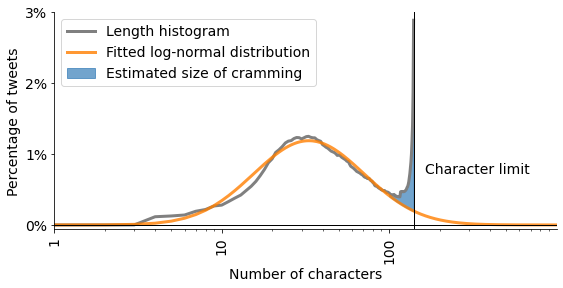

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(9,4))
max_x = 1000
plt.rcParams['font.size'] = 9

before_lognormal = [lognorm.pdf(x, s=sigma2, loc=0, scale=np.exp(mu2-0.01)) for x in range(1, max_x)]
after_lognormal = [lognorm.pdf(x, s=sigma_after, loc=0, scale=np.exp(mu_after)) for x in range(1, max_x)]


ax.set_xlim(1, max_x)
ax.set_xscale("log")
ax.set_xlabel("")



ax.plot(range(1, 141), hist_before, color='gray', linestyle = '-', linewidth = 3, label = 'Length histogram')

ax.plot(range(1, max_x), before_lognormal,\
    color='#ff7f00', linestyle='-', alpha = 0.8,linewidth = 3, label ='Fitted log-normal distribution')

ax.set_ylim(-0.0006312482890484245, 0.03)


ax.axvline(x=140, color='black', linewidth = 1)
ax.axhline(y=0, color='black', linewidth = 1)
ax.set_xticks([1,10,100])

ax.set_xticklabels([1,10,100], fontsize = 14, rotation = 90)

ax.set_yticks([0,0.01,0.02,0.03])
ax.set_yticklabels(['0%','1%','2%','3%'],fontsize = 14)

ax.fill_between(range(100, 141), hist_before[100-1:140],\
                 np.array(before_lognormal[100:141]), \
            color='#377eb8', label="Estimated size of cramming", alpha = 0.7)

plt.legend(fontsize= 14)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_ylabel('Percentage of tweets', fontsize= 14)
ax.set_xlabel('Number of characters', fontsize= 14, x = 0.5)

ax.annotate('  Character limit\n', fontsize= 14, xy=(145,before_lognormal[0]+0.005))

# (140 characters)
plt.savefig("diagram_2.pdf", bbox_inches='tight')

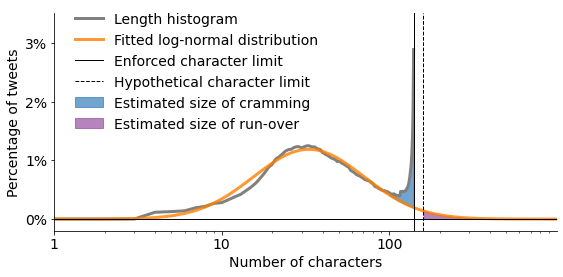

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(9,4))
max_x = 1000
plt.rcParams['font.size'] = 9

before_lognormal = [lognorm.pdf(x, s=sigma2, loc=0, scale=np.exp(mu2-0.01)) for x in range(1, max_x)]
after_lognormal = [lognorm.pdf(x, s=sigma_after, loc=0, scale=np.exp(mu_after)) for x in range(1, max_x)]


ax.set_xlim(1, max_x)
ax.set_xscale("log")
ax.set_xlabel("")



ax.plot(range(1, 141), hist_before, color='gray', linestyle = '-', linewidth = 3, label = 'Length histogram')

ax.plot(range(1, max_x), before_lognormal,\
    color='#ff7f00', linestyle='-', alpha = 0.8,linewidth = 3, label ='Fitted log-normal distribution')





ax.axhline(y=0, color='black', linewidth = 1)
ax.axvline(x=140, color='black', linewidth = 1,label = 'Enforced character limit')
ax.axvline(x=160, color='black', linewidth = 1, linestyle = '--',label = 'Hypothetical character limit')

ax.set_xticks([1,10,100])

ax.set_xticklabels([1,10,100], fontsize = 14)

ax.set_yticks([0,0.01,0.02,0.03,0.04])
ax.set_yticklabels(['0%','1%','2%','3%','4%'],fontsize = 14)


ax.fill_between(range(100, 141), hist_before[100-1:140],\
                 np.array(before_lognormal[100:141]), \
            color='#377eb8', label="Estimated size of cramming", alpha = 0.7)

ax.fill_between(range(161, max_x, 1), before_lognormal[160:],\
                        [0] * len(before_lognormal[160:]),
                color='#984ea3', label="Estimated size of run-over", alpha = 0.7)

plt.legend(fontsize= 14, bbox_to_anchor = (0.55,0.4), frameon=False)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_ylabel('Percentage of tweets', fontsize= 14)
ax.set_xlabel('Number of characters', fontsize= 14, x = 0.5)

#ax.annotate('Hypothetical\ncharacter limit\n', fontsize= 14, xy=(180,before_lognormal[0]+0.032))

#ax.annotate('Enforced\ncharacter limit\n', fontsize= 14, xy=(30,before_lognormal[0]+0.032))

# (140 characters)
ax.set_ylim(-0.002, 0.035)
plt.savefig("diagram_2.pdf", bbox_inches='tight')

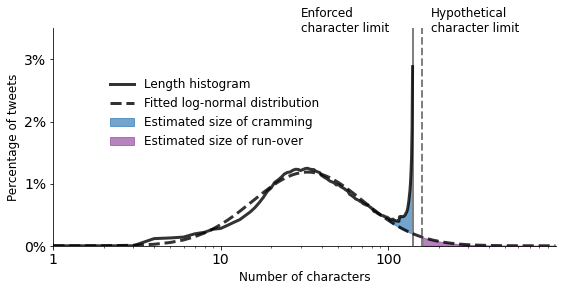

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(9,4))
max_x = 1000
plt.rcParams['font.size'] = 9

before_lognormal = [lognorm.pdf(x, s=sigma2, loc=0, scale=np.exp(mu2-0.01)) for x in range(1, max_x)]
after_lognormal = [lognorm.pdf(x, s=sigma_after, loc=0, scale=np.exp(mu_after)) for x in range(1, max_x)]


ax.set_xlim(1, max_x)
ax.set_xscale("log")
ax.set_xlabel("")

ax.axvline(x=140, linewidth = 2, color = 'gray')
ax.axvline(x=160, linewidth = 2, linestyle = '--', color = 'gray') 

ax.plot(range(1, 141), hist_before, color='black', linestyle = '-', linewidth = 3,alpha = 0.8, label = 'Length histogram')

ax.plot(range(1, max_x), before_lognormal,\
    color='black', linestyle='--', alpha = 0.8,linewidth = 3, label ='Fitted log-normal distribution')



ax.axhline(y=0, color='black', linewidth = 1)


ax.set_xticks([1,10,100])

ax.set_xticklabels([1,10,100], fontsize = 14)

ax.set_yticks([0,0.01,0.02,0.03,0.04])
ax.set_yticklabels(['0%','1%','2%','3%','4%'],fontsize = 14)


ax.fill_between(range(100, 141), hist_before[100-1:140],\
                 np.array(before_lognormal[100:141]), \
            color='#377eb8', label="Estimated size of cramming", alpha = 0.7)

ax.fill_between(range(161, max_x, 1), before_lognormal[160:],\
                        [0] * len(before_lognormal[160:]),
                color='#984ea3', label="Estimated size of run-over", alpha = 0.7)

plt.legend(fontsize= 12, bbox_to_anchor = (0.55,0.4), frameon=False)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_ylabel('Percentage of tweets', fontsize= 12)
ax.set_xlabel('Number of characters', fontsize= 12, x = 0.5)

ax.annotate('Hypothetical\ncharacter limit\n', fontsize= 12, xy=(180,before_lognormal[0]+0.032))

ax.annotate('Enforced\ncharacter limit\n', fontsize= 12, xy=(30,before_lognormal[0]+0.032))

# (140 characters)
ax.set_ylim(0, 0.035)
plt.savefig("diagram_2.pdf", bbox_inches='tight')

In [15]:
df = pd.read_csv("../data/measurements/fig6_cramming_per_lang_before_vs_after.csv.gz")

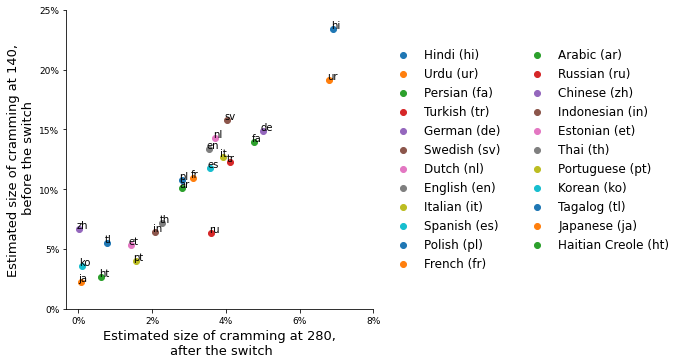

In [16]:

lang_sorted = ['ht', 'ja', 'tl', 'ko', 'pt', 'th',\
               'et' ,'in', 'zh', 'ru', 'ar', 'fr',\
               'pl', 'es', 'it', 'en', 'nl', 'sv', \
               'de','tr', 'fa', 'ur', 'hi']

mapping_lang_codes = {'ja': 'Japanese',
                      'en': 'English',
                      'pt': 'Portuguese',
                      'es': 'Spanish',
                      'ar': 'Arabic',
                      'ko': 'Korean',
                      'in': 'Indonesian',
                      'tl': 'Tagalog',
                      'tr': 'Turkish',
                      'fr': 'French',
                      'th': 'Thai',
                      'ru': 'Russian',
                      'it': 'Italian',
                      'de': 'German',
                      'pl': 'Polish',
                      'hi': 'Hindi',
                      'fa': 'Persian',
                      'nl': 'Dutch',
                      'ht': 'Haitian Creole',
                      'et': 'Estonian',
                      'zh': 'Chinese',
                      'ur': 'Urdu',
                      'sv': 'Swedish'}

# one column legend
fig, ax = plt.subplots(1,1,figsize= (5.5, 5.5))

for i in range(22, -1, -1):
    lang = lang_sorted[i]
    x_value = df[df.lang == lang].cramming_after_280.iloc[0]
    y_value = df[df.lang == lang].cramming_before_140.iloc[0]
    plt.scatter(x_value, y_value,\
                label = mapping_lang_codes[lang_sorted[i]] + " (" + lang_sorted[i] + ")")
    ax.annotate(lang_sorted[i], (x_value-0.0007, y_value+0.0008), fontsize= 10)
    
    

plt.ylabel('Estimated size of cramming at 140,\n before the switch', fontsize = 13)
plt.xlabel('Estimated size of cramming at 280,\n after the switch', fontsize = 13)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.xticks([0., 0.02, 0.04, 0.06, 0.08], ["0%", "2%", "4%", "6%", "8%"])
plt.yticks([0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25],["0%", "5%", "10%", "15%", "20%", "25%"])
plt.grid(False) 
plt.legend(ncol=2, loc='right', bbox_to_anchor=(2,0.5), frameon=False, fontsize=12)
plt.savefig("scatter_140vs280cramming.pdf", bbox_inches='tight');

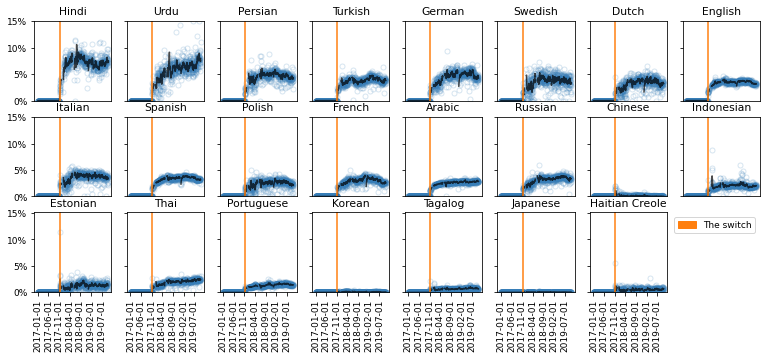

In [21]:
import math 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import pandas as pd
import numpy as np

df = pd.read_csv("../data/measurements/fig7_daily_cramming_all_langs.csv.gz", index_col='date')
df.index = pd.to_datetime(df.index)
dates = df.index.drop_duplicates()
first_in_month_index = dates[dates.day == 1].values
month_label = dates[dates.day == 1].astype(str).values

fig, axes = plt.subplots(3, 8, figsize=(13,5), sharey=False, sharex=False)

for cnt_lang, lang in enumerate(((lang_sorted[::-1]))):
    
    ax = axes[math.floor(cnt_lang / 8), cnt_lang % 8]
    
    #ax.axvspan(pd.Timestamp("2018-05-09"), pd.Timestamp("2018-06-01"), ymin=0, ymax=1, alpha=0.2, color='gray')
    #ax.axvspan(pd.Timestamp("2018-12-10"), pd.Timestamp("2018-12-23"), ymin=0, ymax=1, alpha=0.2, color='gray')

    ax.plot(df[df.lang == lang].cramming280, linestyle='none', marker='o', markersize=5, 
             fillstyle='none', alpha=0.2, color='#377eb8')

    smoothed = df[df.lang == lang].cramming280.rolling(10, min_periods=2).mean()

    smoothed[335:364] = np.nan
    smoothed[493:520] = np.nan
    smoothed[708:721] = np.nan

    ax.plot(smoothed, color='black', alpha=0.7)
    
    ax.set_title(mapping_lang_codes[lang])
    ax.grid(False)
    ax.set_ylim([0, 0.151])
    
    if cnt_lang % 8 == 0:

        ax.set_yticks([0, 0.05, 0.1, 0.15])
        ax.set_yticklabels(['0%','5%','10%','15%'])

    else:
        ax.set_yticks([0, 0.05, 0.1, 0.15])
        ax.set_yticklabels(["", "", "", ""])
    
    if cnt_lang > 15:
        ax.set_xticks(first_in_month_index[::5])
        ax.set_xticklabels(month_label[::5].tolist(),  rotation=90);
        ax.xaxis.set_tick_params(rotation=90)

    else:
        ax.set_xticks([])
        
    ax.axvline(pd.Timestamp("2017-11-07"), ymin=-0.01, ymax=1, color='tab:orange', label='The switch')
    ax.grid(axis='x',b = False) 
    ax.grid(axis='y',b = False) 

ax = axes[2,7]
ax.grid(False) 
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

blue_patch = mpatches.Patch(color='tab:orange', label='The switch')
ax.legend(handles=[blue_patch])

#plt.suptitle('Estimated size of cramming at 280', y=0.95)
#fig.text(0.5, -0.03, 'date', ha='center')
#fig.text(0.095, 0.5, 'Cramming', va='center', rotation='vertical');

plt.savefig("daily_cramming_per_language.pdf", bbox_inches='tight');